In [ ]:
!pip install -Uq diffusers transformers fastcore

     |████████████████████████████████| 255 kB 37.9 MB/s 
     |████████████████████████████████| 5.3 MB 61.7 MB/s 
     |████████████████████████████████| 163 kB 74.4 MB/s 
     |████████████████████████████████| 7.6 MB 55.1 MB/s 


In [ ]:
from fastcore.all import concat
import torch, logging
from pathlib import Path
from huggingface_hub import notebook_login
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
logging.disable(logging.WARNING)

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers import LMSDiscreteScheduler

In [ ]:
beta_start,beta_end = 0.00085,0.012
scheduler = LMSDiscreteScheduler(beta_start=beta_start, beta_end=beta_end, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [ ]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16)
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14", torch_dtype=torch.float16).to("cuda")

# Here we use a different VAE to the original release, which has been fine-tuned for more steps
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema", torch_dtype=torch.float16).to("cuda")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", torch_dtype=torch.float16).to("cuda")

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

In [ ]:
prompts = [
    'a photograph of an astronaut riding a horse',
    'an oil painting of an astronaut riding a horse in the style of grant wood'
]

height = 512
width = 512
num_inference_steps = 70
guidance_scale = 7.5
batch_size = 1

In [ ]:
text_input = tokenizer(prompts, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_embeddings = text_encoder(text_input.input_ids.to("cuda"))[0].half()

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * len(prompts), padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to("cuda"))[0].half()
emb = torch.cat([uncond_embeddings, text_embeddings])

In [ ]:
torch.manual_seed(100)
g = guidance_scale

In [ ]:
scheduler.set_timesteps(num_inference_steps)

In [ ]:
latents = torch.randn((len(prompts), unet.in_channels, height//8, width//8))
scheduler.set_timesteps(num_inference_steps)
latents = latents.to("cuda").half() * scheduler.init_noise_sigma

In [ ]:
for i,ts in enumerate(tqdm(scheduler.timesteps)):
    inp = scheduler.scale_model_input(torch.cat([latents] * 2), ts)
    with torch.no_grad(): u,t = unet(inp, ts, encoder_hidden_states=emb).sample.chunk(2)
    pred = u + g*(t-u)
    latents = scheduler.step(pred, ts, latents).prev_sample

  0%|          | 0/70 [00:00<?, ?it/s]

In [ ]:
with torch.no_grad(): image = vae.decode(1 / 0.18215 * latents).sample
res = (image / 2 + 0.5).clamp(0, 1)

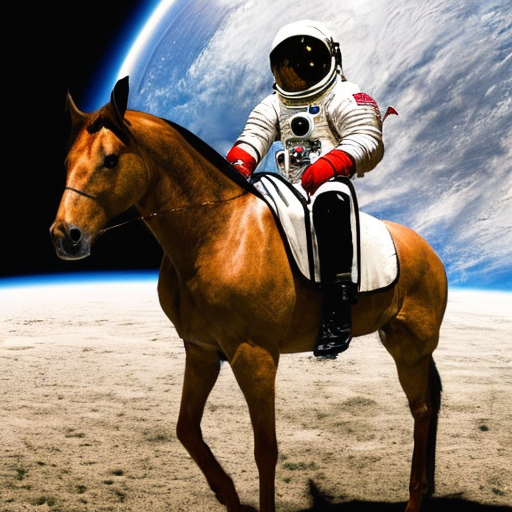

In [ ]:
image = res[0].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)

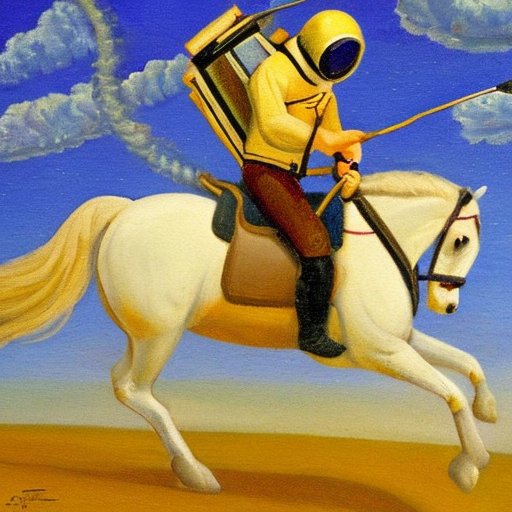

In [ ]:
image = res[1].detach().cpu().permute(1, 2, 0).numpy()
image = (image * 255).round().astype("uint8")
Image.fromarray(image)